## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
class args:
    filename = "atsp12062020.gml"
    scale = 40
    figsize = 30,30

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 28 nodes and 756 edges


In [7]:
G.nodes(data=True)

NodeDataView({1: {'y': 32, 'x': 17}, 2: {'y': 18, 'x': 17}, 3: {'y': 13, 'x': 2}, 4: {'y': 31, 'x': 6}, 5: {'y': 22, 'x': 13}, 6: {'y': 31, 'x': 18}, 7: {'y': 39, 'x': 7}, 8: {'y': 16, 'x': 8}, 9: {'y': 14, 'x': 11}, 10: {'y': 32, 'x': 14}, 11: {'y': 34, 'x': 9}, 12: {'y': 31, 'x': 7}, 13: {'y': 21, 'x': 6}, 14: {'y': 37, 'x': 25}, 15: {'y': 17, 'x': 25}, 16: {'y': 22, 'x': 9}, 17: {'y': 2, 'x': 14}, 18: {'y': 17, 'x': 12}, 19: {'y': 1, 'x': 6}, 20: {'y': 33, 'x': 22}, 21: {'y': 32, 'x': 30}, 22: {'y': 33, 'x': 6}, 23: {'y': 11, 'x': 21}, 24: {'y': 33, 'x': 1}, 25: {'y': 19, 'x': 29}, 26: {'y': 21, 'x': 11}, 27: {'y': 22, 'x': 1}, 28: {'y': 35, 'x': 6}})

## Capacitated Vehicle Routing Problem

>**Given** A fleet of identical vehicles, with limited capacity, located at a depot; $n$ customers that require service with known demand; cost of travel between any pair of customers, or between any customer and the depot.

>**Find** A minimum-cost collection of vehicle routes, each starting and ending at the depot, such that each customer is visited by exactly one vehicle, and no vehicle visits a set of customers whose total demand exceeds the vehicle capacity.

Let $G=(V,A)$ be a directed graph with node $1$ representing the depot and $V_C=V\setminus{1}$ representing the customers.
The (positive integer) demand of customer $i \in V_C$ is denoted by $q_i$.
For any set of customer $S \subset V_C$ let $q(S)=\sum_{i \in S} q_i$.

### Single commodity flow formulation


$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is some vehicle travels from $i$ to $j$} \\
0 \text{ otherwise}
\end{cases}
$$


$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} \\
\text{subject}& \text{ to} \\
\sum_{j \in \delta^+(i)} x_{ij} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} x_{ji} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} & = q_i \;\;\forall i \in V_C\\
 q_j x_{ij} \le f_{ij} & \le (Q-q_i) x_{ij}  \;\; \forall (i,j) \in A\\
\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
\end{align}
$$


In [65]:
cvrp = gb.Model()

# Vehicle capacity 
Q = 20 

# Node demand
dem = {i:1 for i in G.nodes()}

depots = [1,3]

# Depots does not require service
for depot in depots:
    dem[depot] = 0

x = cvrp.addVars(G.edges(), 
                 obj=[G[i][j]['dist'] for i,j in G.edges()],
                 vtype = gb.GRB.BINARY, name='x')

f = cvrp.addVars (G.edges(), obj=0.0, lb=0,
                  ub=Q, vtype=gb.GRB.CONTINUOUS, name='f')


# Forward/Reverse star
cvrp.addConstrs((x.sum(i,'*') == 1 for i in G.nodes() if i not in depots), name='FS')
cvrp.addConstrs((x.sum('*',i) == 1 for i in G.nodes() if i not in depots), name='RS')


# Flow constraints
cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') == dem[i] for i in G.nodes() if i not in depots), name='FLOW')


cvrp.addConstrs((f[i,j] <= (Q - dem[i]) * x[i,j] for i,j in G.edges()),name='VUB')
cvrp.addConstrs((f[i,j] >= dem[j] * x[i,j] for i,j in G.edges()),name='VLB')


cvrp.update()
cvrp.write('cvrp.lp')

In [66]:
depot_costs = {1:100,3:180}

dg = cvrp.addVars(depots, 
                 obj=[depot_costs[depot] for depot in depots],
                 vtype = gb.GRB.CONTINUOUS, name='dg')

for depot in depots:
    cvrp.addConstr(f.sum(depot,'*') <= dg[depot] ,name='depot_goods_constr')
    
    cvrp.addConstr(x.sum(depot,'*')-x.sum('*',depot) == 0 ,name='vehicle_must_return')
    

cvrp.update()

In [67]:
root = 1

u = cvrp.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

# Fixing root node
u[root].lb = 1.0
u[root].ub = 1.0


cvrp.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)
                   for i in G.nodes() for j in G.nodes()
                   if (i != j) and (i != root) and (j !=root) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

cvrp.update()

In [68]:
cvrp.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2296 rows, 1542 columns and 8750 nonzeros
Model fingerprint: 0x1fbd2595
Variable types: 786 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 58 rows and 5 columns
Presolve time: 0.01s
Presolved: 2238 rows, 1537 columns, 8636 nonzeros
Variable types: 781 continuous, 756 integer (756 binary)
Found heuristic solution: objective 78893.000000

Root relaxation: objective 1.867410e+04, 1066 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18674.1025    0   57 78893.0000 18674.1025  76.3%     -    0s
H    0     0                    20926.0

Solution:  19880.0


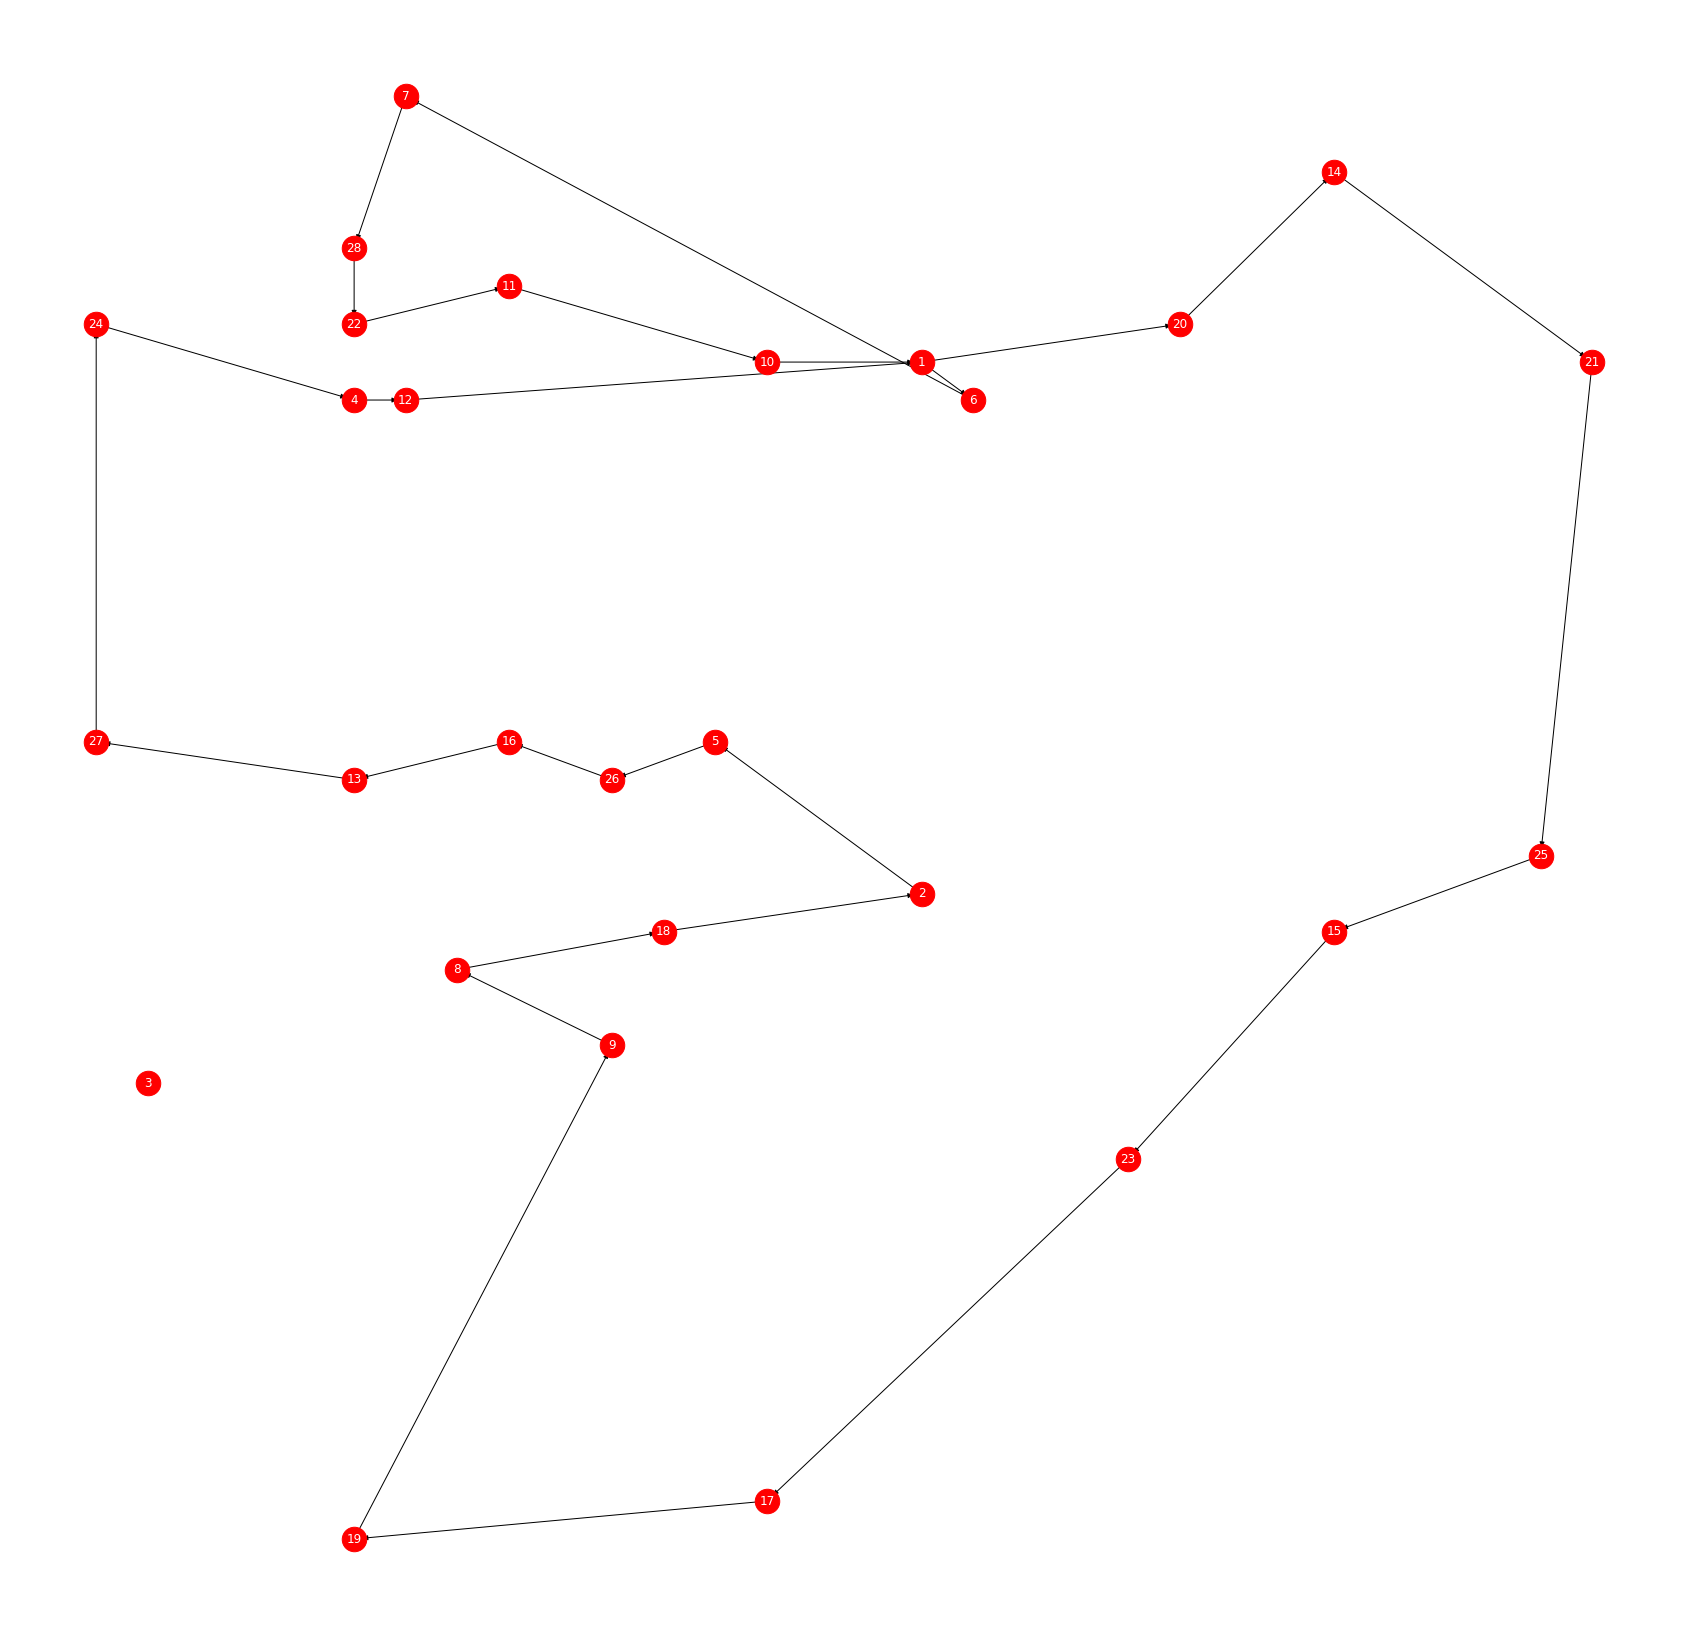

In [69]:
print("Solution: ", cvrp.objVal)
DrawSol(G, x)